## Response length vs ChatGPT Grade Analysis

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [6]:
df = pd.read_excel('combined_responses_scores_added.xlsx', usecols=lambda x: 'Unnamed' not in x)

In [7]:
reduced_df = df[df['Re-Prompted'] == 'No']
reduced_df = reduced_df.dropna(subset=['ChatGPT Score'])
reduced_df = reduced_df[['Response Word Count', 'ChatGPT % Score']]

In [8]:
response_count_array = np.array(reduced_df['Response Word Count'])
chatgpt_score_array = np.array(reduced_df['ChatGPT % Score'])
corr_base = np.corrcoef(response_count_array, chatgpt_score_array)
print(f'Correlation: {round(corr_base[0, 1], 3)}')
print(f'Mean: {round(np.mean(chatgpt_score_array), 3)}')
print(f'StDev: {round(np.std(chatgpt_score_array), 3)}')

Correlation: 0.211
Mean: 0.868
StDev: 0.103


In [9]:
non_math_df = df[df['Re-Prompted'] == 'No']
non_math_df = non_math_df[non_math_df['Instructor'] != 'Darryl']
non_math_df = non_math_df.dropna(subset=['ChatGPT Score'])
non_math_df = non_math_df[['Response Word Count', 'ChatGPT % Score']]

non_math_response_count_array = np.array(non_math_df['Response Word Count'])
non_math_chatgpt_score_array = np.array(non_math_df['ChatGPT % Score'])
non_math_corr_base = np.corrcoef(non_math_response_count_array, non_math_chatgpt_score_array)
round(non_math_corr_base[0, 1], 3)

np.float64(0.198)

In [10]:
def display_skew_stats(array):
    params = stats.skewnorm.fit(array)
    a, mean, stdev = params
    dict = {
        'a': a, 
        'mean': mean, 
        'stdev': stdev
    }
    return dict

def create_skewed_data(array):
    params = stats.skewnorm.fit(array)
    a, mean, stdev = params
    rand_skew_data = stats.skewnorm(a, mean, stdev).rvs(len(array))

    capped_data = []
    for value in list(rand_skew_data):
        if value > 1:
            capped_data.append(1)
        else:
            capped_data.append(round(value, 2))
    return capped_data

def summary_stats(list):
    dict = {
        'min': min(list),
        'max': max(list),
        'average': round(np.mean(list), 3),
        'stdev': round(np.std(list), 3)
    }
    return dict

def cap_list_at_one(list):
    new_list = []
    for item in list:
        if item > 1:
            new_list.append(1)
        else:
            new_list.append(item)
    return new_list

def percent_near_point_two(list):
    nearly_two = sum(np.array(list) > 0.2)
    nearly_neg_two = sum(np.array(list) < -0.2)
    amount_corr = nearly_two+nearly_neg_two
    percent_decent_corr = amount_corr / len(list)
    return percent_decent_corr

In [11]:
def corr_trials(chatgpt_score_array, num_of_trials, distribution_type):
    length_chatgpt = len(chatgpt_score_array)
    mean_chatgpt = np.mean(chatgpt_score_array)
    stdev_chatgpt = np.std(chatgpt_score_array)

    list_of_rand_data = []
    if distribution_type == 'skewed':
        for index in range(0, num_of_trials):
            temp_rand_data = cap_list_at_one(create_skewed_data(chatgpt_score_array))
            list_of_rand_data.append(temp_rand_data)
    elif distribution_type == 'normal':
        for index in range(0, num_of_trials):
            temp_rand_data = cap_list_at_one(np.random.normal(loc=mean_chatgpt, scale=stdev_chatgpt, size=length_chatgpt))
            list_of_rand_data.append(temp_rand_data)
    elif distribution_type == 'uniform':
        for index in range(0, num_of_trials):
            uniform_low = mean_chatgpt - (2*stdev_chatgpt)
            temp_rand_data = np.random.uniform(low=uniform_low, high=1, size=length_chatgpt)
            list_of_rand_data.append(temp_rand_data)

    list_of_corr = []
    for rand_data in list_of_rand_data:
        temp_corr = round(np.corrcoef(response_count_array, rand_data)[0,1], 3)
        list_of_corr.append(temp_corr)

    return [list_of_rand_data, list_of_corr]

In [12]:
skewed_data, skewed_corr = corr_trials(chatgpt_score_array, 10000, 'skewed')
normal_data, normal_corr = corr_trials(chatgpt_score_array, 10000, 'normal')
uniform_data, uniform_corr = corr_trials(chatgpt_score_array, 10000, 'uniform')

In [14]:
print(summary_stats(skewed_corr))
print(percent_near_point_two(skewed_corr))

{'min': np.float64(-0.315), 'max': np.float64(0.255), 'average': np.float64(0.0), 'stdev': np.float64(0.08)}
0.0129


In [15]:
print(summary_stats(normal_corr))
print(percent_near_point_two(normal_corr))

{'min': np.float64(-0.348), 'max': np.float64(0.321), 'average': np.float64(0.0), 'stdev': np.float64(0.08)}
0.011


In [16]:
print(summary_stats(uniform_corr))
print(percent_near_point_two(uniform_corr))

{'min': np.float64(-0.291), 'max': np.float64(0.281), 'average': np.float64(0.0), 'stdev': np.float64(0.08)}
0.0124


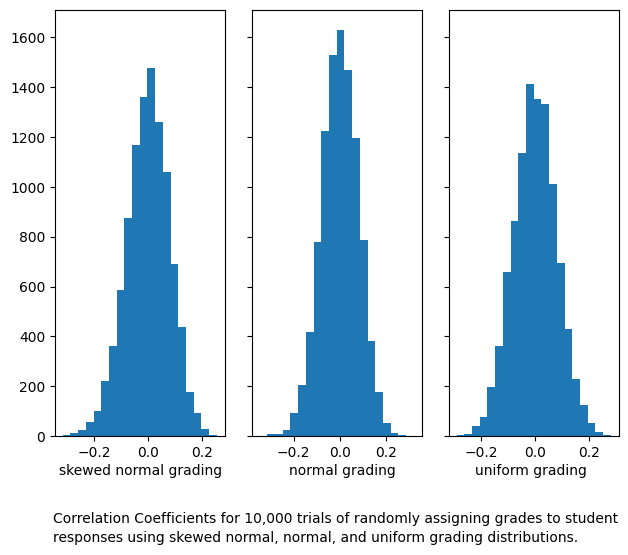

In [17]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
num_of_bins = 20

axs[0].hist(skewed_corr, bins=num_of_bins)
axs[1].hist(normal_corr, bins=num_of_bins)
axs[2].hist(uniform_corr, bins=num_of_bins)

plt.figtext(0.1, 0, "skewed normal grading")
plt.figtext(0.46, 0, "normal grading")
plt.figtext(0.75, 0, "uniform grading")
plt.figtext(0.09, -0.1, "Correlation Coefficients for 10,000 trials of randomly assigning grades to student")
plt.figtext(0.09, -0.14, "responses using skewed normal, normal, and uniform grading distributions.")

plt.show()

In [18]:
display_skew_stats(chatgpt_score_array)

{'a': np.float64(-43520391.47704343),
 'mean': np.float64(1.0000000204648525),
 'stdev': np.float64(0.16731195916253927)}

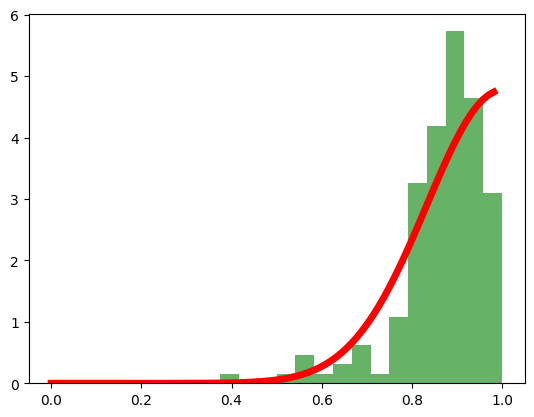

In [19]:
fig, ax = plt.subplots(1, 1)

#ax.scatter(chatgpt_score_array, response_count_array)

ax.hist(chatgpt_score_array, bins=15, density=1, alpha=0.6, color='g')

a = display_skew_stats(chatgpt_score_array)['a']
loc = display_skew_stats(chatgpt_score_array)['mean']
scale = display_skew_stats(chatgpt_score_array)['stdev']

rv = stats.skewnorm(a)
x = np.linspace(0, 1.2, 100)
y = stats.skewnorm.pdf(x, a, loc, scale)
ax.plot(x[:82], y[:82], 'r-', lw=5)

plt.show()

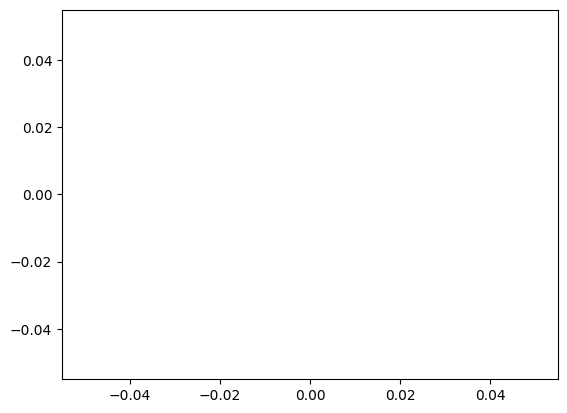

In [20]:
fig, ax = plt.subplots(1, 1)

a = 4
#mean, var, skew, kurt = stats.skewnorm.stats(a, moments='mvsk')
x = cap_list_at_one(np.linspace(stats.skewnorm.ppf(0.01, a), stats.skewnorm.ppf(1.19, a), 100))
ax.plot(x, stats.skewnorm.pdf(x, a),
       'r-', lw=5, alpha=0.6, label='skewnorm pdf')

plt.show()

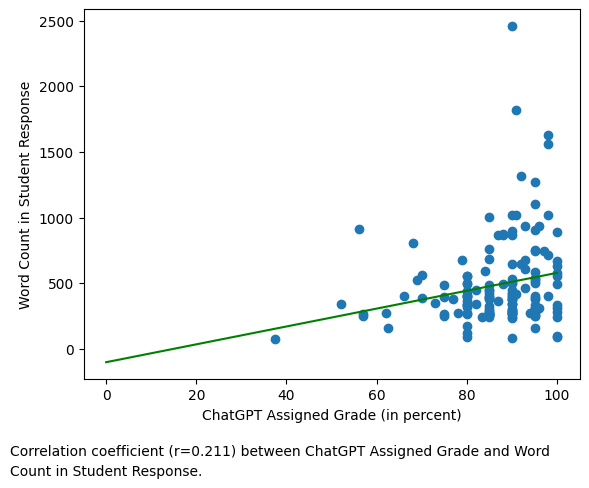

In [21]:
fig, ax = plt.subplots(1, 1)

ax.scatter(chatgpt_score_array*100, response_count_array)
plt.xlabel("ChatGPT Assigned Grade (in percent)")
plt.ylabel("Word Count in Student Response")

lin_curve = np.polyfit(chatgpt_score_array*100, response_count_array, deg=1)
#log_curve = np.polyfit(np.log(chatgpt_score_array*100), np.log(response_count_array), deg=1)

x_seq = np.linspace(0.01, 100, num=100)
ax.plot(x_seq, lin_curve[1]+(lin_curve[0]*x_seq), color='g')
#ax.plot(x_seq, log_curve[0]*np.log(x_seq)+log_curve[1], color='r')

plt.figtext(0.01, -0.05, "Correlation coefficient (r=0.211) between ChatGPT Assigned Grade and Word")
plt.figtext(0.01, -0.09, "Count in Student Response.")

plt.show()